<a href="https://colab.research.google.com/github/Lakshika-Swarnamali/FYP_UoM/blob/master/LSA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [2]:
log = pd.read_csv("https://raw.githubusercontent.com/GihanKLG/TwitterCovid19Dataset/master/2020-10-12.csv",encoding='latin1')
log[(log['lang'] == 'en')].to_csv("out.csv", index=False)
log = pd.read_csv('out.csv', lineterminator='\n',encoding='latin1')
log.head()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
0,NaN,Sun Oct 11 23:59:54 +0000 2020,NaN,NaN,NaN,0,1315442032651927552,BalutSmithy,1.315403e+18,1.296441e+18,en,NaN,NaN,0,NaN,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@BalutSmithy @StephenJohn59 @jaketapper @kaitl...,https://twitter.com/NorthLapp/status/131544203...,Sun Mar 25 19:25:10 +0000 2012,NorthLapp,False,"I need more followers, I will expose the truth...",1979,1291,1805,28,NaN,Renee J North Lapp,NorthLapp,12503,NaN,NaN,False
1,NaN,Sun Oct 11 23:59:56 +0000 2020,NaN,NaN,NaN,0,1315442037286678529,NaN,NaN,NaN,en,NaN,NaN,1,1.315348e+18,PetraCEsser1,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @PetraCEsser1: @HSRetoucher Thank you. I am...,https://twitter.com/johncoppa44/status/1315442...,Fri Feb 26 09:25:23 +0000 2016,johncoppa44,True,NaN,3031,31,287,1,NaN,john coppa,johncoppa44,7490,NaN,NaN,False
2,NaN,Sun Oct 11 23:59:56 +0000 2020,NaN,NaN,https://twitter.com/onlinelonghorn/status/1315...,0,1315442039870324736,NaN,NaN,NaN,en,NaN,False,0,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",*corona liked this post* https://t.co/3mAPNWNAfK,https://twitter.com/ivythekingrat/status/13154...,Mon Dec 11 16:09:37 +0000 2017,ivythekingrat,False,nope,4001,95,153,0,puerto rico,rat zone,ivythekingrat,1633,NaN,NaN,False
3,NaN,Sun Oct 11 23:59:55 +0000 2020,SidNaaz,NaN,NaN,0,1315442036028260353,NaN,NaN,NaN,en,NaN,NaN,120,1.315334e+18,SidNaaz13Dstny,"<a href=""http://twitter.com/download/android"" ...",RT @SidNaaz13Dstny: Points\n\n1. Salman Sir #S...,https://twitter.com/Tejakshi1/status/131544203...,Sat Jan 04 06:50:54 +0000 2020,Tejakshi1,False,Ã°ÂÂ¤Â¡,57815,282,579,0,NaN,tejakshi shetty,Tejakshi1,39117,NaN,NaN,False
4,NaN,Sun Oct 11 23:59:55 +0000 2020,NaN,NaN,NaN,0,1315442033331507203,NaN,NaN,NaN,en,NaN,NaN,10711,1.315345e+18,CLewandowski_,"<a href=""http://twitter.com/#!/download/ipad"" ...",RT @CLewandowski_: WHO now advising against lo...,https://twitter.com/LoisR52511816/status/13154...,Sun Aug 02 16:10:47 +0000 2020,LoisR52511816,True,NaN,28886,88,277,0,NaN,LoisR,LoisR52511816,13602,NaN,NaN,False


In [3]:
# importing pandas package
import pandas as pd
 
# making data frame from csv file
data = pd.read_csv("https://raw.githubusercontent.com/GihanKLG/TwitterCovid19Dataset/master/2020-10-12.csv", index_col ="id")
 
# retrieving columns by indexing operator
my_column_names = [ 'user_name','text']
df = pd.DataFrame(data=data, columns=my_column_names)
lsa = pd.DataFrame(data=data, columns=my_column_names)

df.head(10)

,user_name,text
id,,
1315442032651927552,Renee J North Lapp,@BalutSmithy @StephenJohn59 @jaketapper @kaitl...
1315442033507684352,🎃 leh 🎃,RT @dougraz: todo dia pensando será se eu ja p...
1315442037286678529,john coppa,RT @PetraCEsser1: @HSRetoucher Thank you. I am...
1315442040172425216,Reivindicación,@PedroAzzola https://t.co/RxL0DAaQaI
1315442039870324736,rat zone,*corona liked this post* https://t.co/3mAPNWNAfK
1315442032350027780,ᴮᴱ#LAKERS 2020 NBA Champions #Titans (5-0),https://t.co/VNNyjhzXxt https://t.co/DRIUE2K2VV
1315442036028260353,tejakshi shetty,RT @SidNaaz13Dstny: Points\n\n1. Salman Sir #S...
1315442038142390274,Angel Duarte Hurtado,RT @AristeguiOnline: Paga México más de 180 mi...
1315442033331507203,LoisR,RT @CLewandowski_: WHO now advising against lo...


In [4]:
# make a new column to highlight retweets
df['is_retweet'] = df['text'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()  # number of retweets

125905

In [5]:
# number of unique retweets
df.loc[df['is_retweet']].text.unique().size

24446

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# pd.set_option("display.max_colwidth", 200)

In [7]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
len(documents)

11314

In [8]:
# news_df = pd.DataFrame({'document':documents})
news_df = pd.DataFrame(df)

# removing everything except alphabets`
news_df['clean_doc'] = news_df['text'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
def prepare_text_for_lsa(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [11]:
def remove_links(text):
    '''Takes a string and removes web links from it'''
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
    text = text.strip('[link]') # remove [links]
    return text

def remove_users(text):
    '''Takes a string and removes retweet and @user information'''
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text) # remove tweeted at
    return text

In [43]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning master function
def clean_tweet(text, bigrams=False):
    text = remove_users(text)
    text = remove_links(text)
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\s+', ' ', text) #remove double spacing
    text = re.sub('([0-9]+)', '', text) # remove numbers
    tweet_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    tweet_token_list = [word_rooter(word) if '#' not in word else word
                        for word in tweet_token_list] # apply word rooter
    if bigrams:
        tweet_token_list = tweet_token_list+[tweet_token_list[i]+'_'+tweet_token_list[i+1]
                                            for i in range(len(tweet_token_list)-1)]
    tweet = ' '.join(tweet_token_list)
    return tweet

In [45]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['seems', 'to', 'me', 'that', 'fauci', 'is', 'also', 'to', 'blame', 'for', 'the', 'mishandling', 'of', 'this', 'pandemic', 'birx', 'too', 'pres', 'listened', 'to', 'their', 'advice', 'of', 'what', 'to', 'do', 'when', 'to', 'do', 'it', 'the', 'pres', 'isnt', 'doctor', 'fauci', 'led', 'his', 'team', 'do', 'you', 'blame', 'fauci', 'so', 'why', 'do', 'you', 'trust', 'fauci', 'he', 'has', 'changed', 'his', 'opinion', 'often']]


In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [14]:
lsa['clean_tweet'] = lsa.text.apply(clean_tweet)
lsa.head(10)

,user_name,text,clean_tweet
id,,,
1315442032651927552,Renee J North Lapp,@BalutSmithy @StephenJohn59 @jaketapper @kaitl...,seem fauci also blame mishandl pandem birx pr...
1315442033507684352,🎃 leh 🎃,RT @dougraz: todo dia pensando será se eu ja p...,todo dia pensando será se eu ja peguei covid ...
1315442037286678529,john coppa,RT @PetraCEsser1: @HSRetoucher Thank you. I am...,thank speak tongu angel bring chip blood brai...
1315442040172425216,Reivindicación,@PedroAzzola https://t.co/RxL0DAaQaI,
1315442039870324736,rat zone,*corona liked this post* https://t.co/3mAPNWNAfK,corona like post
1315442032350027780,ᴮᴱ#LAKERS 2020 NBA Champions #Titans (5-0),https://t.co/VNNyjhzXxt https://t.co/DRIUE2K2VV,
1315442036028260353,tejakshi shetty,RT @SidNaaz13Dstny: Points\n\n1. Salman Sir #S...,point salman sir #sidnaaz shipper h❤️ salma...
1315442038142390274,Angel Duarte Hurtado,RT @AristeguiOnline: Paga México más de 180 mi...,paga méxico má de millon de dl para garantiz...
1315442033331507203,LoisR,RT @CLewandowski_: WHO now advising against lo...,advis lockdown disproportion hurt poor—which ...


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(lsa['clean_tweet'])

X.shape # check shape of the document-term matrix

(166536, 1000)

In [16]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=10, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

10

In [17]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": \n")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 0: 

pandem
 
mask
 
wear
 
save
 
choic
 
doe
 
woman
 
Topic 1: 

covid
 
fauci
 
dr
 
presid
 
campaign
 
ad
 
context
 
Topic 2: 

covid
 
la
 
el
 
en
 
que
 
lo
 
del
 
Topic 3: 

song
 
hear
 
pandem
 
global
 
tell
 
kid
 
swine
 
Topic 4: 

la
 
el
 
en
 
que
 
del
 
lo
 
por
 
Topic 5: 

trump
 
coronaviru
 
day
 
say
 
american
 
said
 
lockdown
 
Topic 6: 

lockdown
 
que
 
nabarro
 
david
 
com
 
om
 
uma
 
Topic 7: 

tell
 
pandem
 
flu
 
global
 
surviv
 
swine
 
kid
 
Topic 8: 

die
 
day
 
thousand
 
said
 
shrug
 
american
 
told
 
Topic 9: 

메신저
 
사랑의
 
평화와
 
die
 
coronaviru
 
american
 
presid
 


In [18]:
# Applying Topic Modelling
from sklearn.feature_extraction.text import CountVectorizer

# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(lsa['clean_tweet']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()
# tf_feature_names

In [22]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [24]:
df['is_retweet'] = df['text'].apply(lambda x: x[:2]=='RT')
df['is_retweet'].sum()  # number of retweets

125905

In [25]:
df.groupby(['text']).size().reset_index(name='counts')\
  .sort_values('counts', ascending=False).head(10)

,text,counts
40345,RT @RBReich: So let me get this straight: wear...,4200
39539,RT @OliviaTroye: The latest @realDonaldTrump c...,3235
48560,RT @joleelachelle: y’all are going out during ...,2950
34694,RT @GFiuza_Oficial: Com o reconhecimento pela ...,1284
38101,"RT @MarshallCohen: Apparently, the Trump campa...",1208
49564,RT @lordxred: Telling my kids I survived 3 glo...,1133
36373,RT @JoeBiden: When President Trump was told on...,1119
43717,"RT @WhiteHouse: ""There is simply no historical...",1035
34053,RT @EmeraldRobinson: RIP in 2020 to the credib...,1011
49273,"RT @larryelder: 'Irreparable damage': Over 6,0...",854


In [26]:
tweets = pd.DataFrame(df)
def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)
# make new columns for mentioned usernames and hashtags
tweets['mentioned'] = tweets.text.apply(find_mentioned)
tweets['hashtags'] = tweets.text.apply(find_hashtags)
tweets.head(5)

,user_name,text,is_retweet,clean_doc,mentioned,hashtags
id,,,,,,
1315442032651927552,Renee J North Lapp,@BalutSmithy @StephenJohn59 @jaketapper @kaitl...,False,balutsmithy stephenjohn jaketapper kaitlancoll...,"[@BalutSmithy, @StephenJohn59, @jaketapper, @k...",[]
1315442033507684352,🎃 leh 🎃,RT @dougraz: todo dia pensando será se eu ja p...,True,dougraz todo pensando peguei covid,[],[]
1315442037286678529,john coppa,RT @PetraCEsser1: @HSRetoucher Thank you. I am...,True,petracesser hsretoucher thank speaking here wi...,[@HSRetoucher],[]
1315442040172425216,Reivindicación,@PedroAzzola https://t.co/RxL0DAaQaI,False,pedroazzola https daaqai,[@PedroAzzola],[]
1315442039870324736,rat zone,*corona liked this post* https://t.co/3mAPNWNAfK,False,corona liked this post https mapnwnafk,[],[]


In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.037*"day" + 0.031*"new" + 0.027*"tell" + 0.026*"die" + 0.025*"vote" + 0.022*"case" + 0.015*"lie" + 0.014*"thing" + 0.012*"number" + 0.011*"today"'), (1, '0.105*"pandemic" + 0.066*"mask" + 0.045*"let" + 0.030*"save_live" + 0.029*"woman_doe" + 0.027*"wear" + 0.016*"month" + 0.014*"oppress" + 0.014*"immune" + 0.013*"give"'), (2, '0.054*"people" + 0.027*"test" + 0.020*"time" + 0.018*"work" + 0.015*"show" + 0.012*"break" + 0.012*"state" + 0.010*"positive" + 0.010*"really" + 0.009*"negative"'), (3, '0.138*"covid" + 0.061*"trump" + 0.052*"campaign" + 0.037*"ad" + 0.037*"president" + 0.034*"amp" + 0.031*"context" + 0.027*"late" + 0.025*"comment" + 0.022*"virus"'), (4, '0.170*"co" + 0.048*"lockdown" + 0.041*"https" + 0.021*"support" + 0.021*"http" + 0.019*"force" + 0.017*"silent" + 0.014*"call" + 0.011*"plan" + 0.009*"ask"')]


In [28]:
hashtags_list_df = df.loc[
                       df.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
# print(hashtags_list_df.head(20))

In [29]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
# print(flattened_hashtags_df.head(20))

In [30]:
# count of appearances of each hashtag
popular_hashtags = flattened_hashtags_df.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)

# print(popular_hashtags.head(20))

In [31]:
# take hashtags which appear at least this amount of times
min_appearance = 150
# find popular hashtags - make into python set for efficiency
popular_hashtags_set = set(popular_hashtags[
                           popular_hashtags.counts>=min_appearance
                           ]['hashtag'])

# print(popular_hashtags_set)

In [32]:
# make a new column with only the popular hashtags
hashtags_list_df['popular_hashtags'] = hashtags_list_df.hashtags.apply(
            lambda hashtag_list: [hashtag for hashtag in hashtag_list
                                  if hashtag in popular_hashtags_set])
# drop rows without popular hashtag
popular_hashtags_list_df = hashtags_list_df.loc[
            hashtags_list_df.popular_hashtags.apply(lambda hashtag_list: hashtag_list !=[])]

# print(popular_hashtags_list_df.head(20))

In [33]:
# make new dataframe
hashtag_vector_df = popular_hashtags_list_df.loc[:, ['popular_hashtags']]

for hashtag in popular_hashtags_set:
    # make columns to encode presence of hashtags
    hashtag_vector_df['{}'.format(hashtag)] = hashtag_vector_df.popular_hashtags.apply(
        lambda hashtag_list: int(hashtag in hashtag_list))

# print(hashtag_vector_df.head(20))

                              #COVID19     #vote  ...   #EnVivo  #andrewcuomo
#COVID19                      1.000000 -0.101517  ... -0.124857     -0.108226
#vote                        -0.101517  1.000000  ... -0.016829     -0.012476
#Trump                       -0.043763 -0.012646  ... -0.023784     -0.017631
#EndSARS                     -0.106042 -0.012888  ... -0.017502     -0.012975
#Coronavirus                 -0.090732 -0.024169  ... -0.030143     -0.024333
#KapoldaSulsel               -0.141254 -0.016283  ... -0.022114     -0.016393
#coronavirus                 -0.159344 -0.033683  ... -0.035718     -0.033911
#MAGA                        -0.105216 -0.008662  ... -0.019688     -0.014595
#TyphoidMary                 -0.124809 -0.014387  ... -0.019539     -0.014485
#WearAMask                   -0.091892  0.004584  ... -0.022114     -0.016393
#OpsYustisiPoldaSulsel       -0.141254 -0.016283  ... -0.022114     -0.016393
#COVID__19                   -0.133313 -0.017359  ... -0.023575 

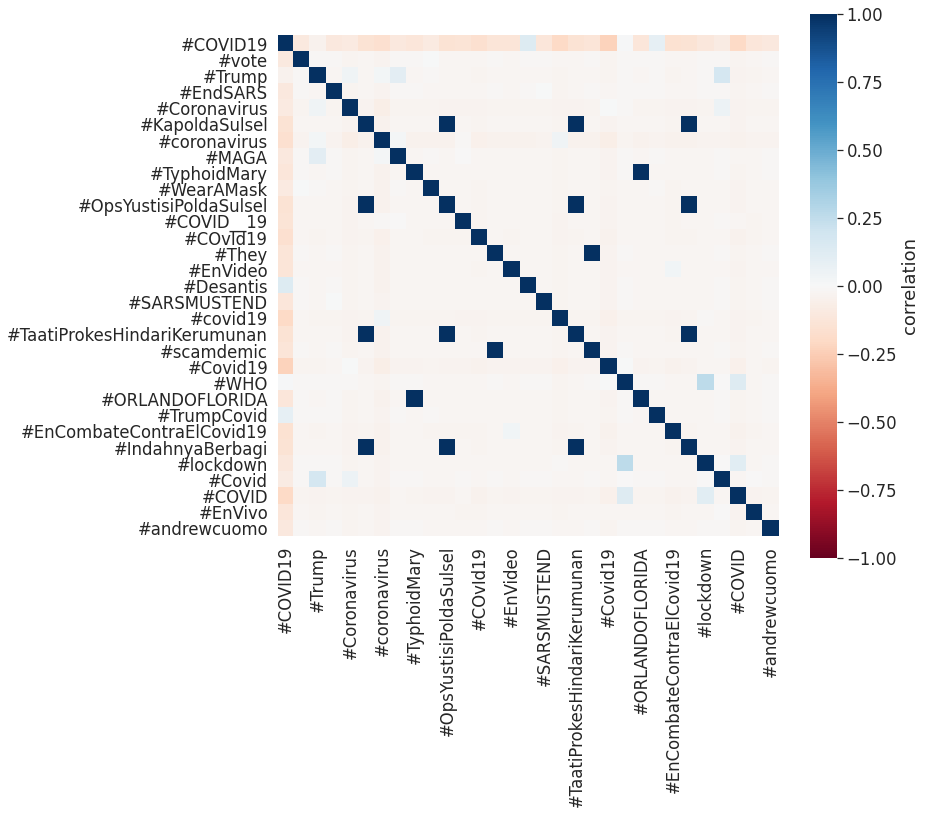

In [34]:
import seaborn as sn
import matplotlib.pyplot as plt

hashtag_matrix = hashtag_vector_df.drop('popular_hashtags', axis=1)

# calculate the correlation matrix
correlations = hashtag_matrix.corr()
print (correlations)
# # plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(correlations,
     cmap='RdBu',
     vmin=-1,
     vmax=1,
     square = True,
     cbar_kws={'label':'correlation'})
plt.show()

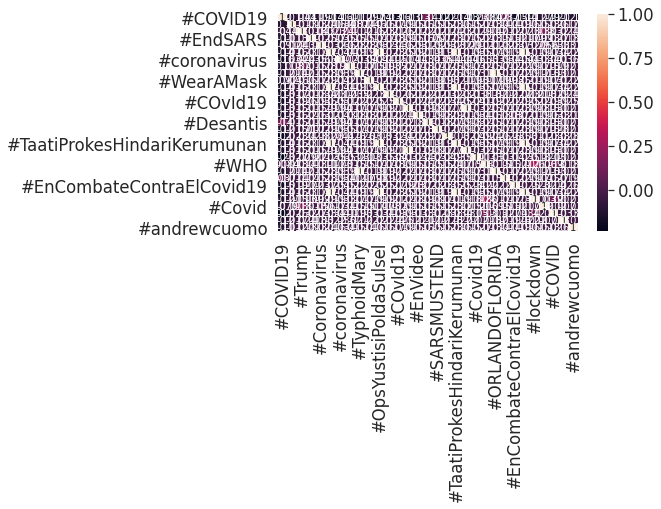

In [35]:
 import seaborn as sn
 import matplotlib.pyplot as plt

 sn.heatmap(correlations, annot=True)
 plt.show()

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

In [48]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lsa = CoherenceModel(model=lda_model, texts=data_ready, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('\nCoherence Score: ', coherence_lsa)


Perplexity:  -8.000311775850028

Coherence Score:  0.29888898430591077
